In [22]:
# insertar librerias
import xarray as xr
import netCDF4
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import pandas as pd
from matplotlib import colors
import contextily as ctx
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import geopandas
import rasterio
import rioxarray
import xarray
import matplotlib.image as mpimg
import Hackaton_CCC


# Vínculo entre retroceso de glaciares y aumento de temperaturas sumado a efecto sequía

Para poder responder la pregunta de si efectivamente hay relación entre el aumento de temperaturas y la disminución de precipitaciones en la cuenca del Río Olivares, se debe medir ambas variables y evaluarlas en su dimensión espacial y temporal. 

In [3]:
# cargar los archivos NetCDF de precipitacion y media estacional
ds1 = xr.open_dataset('pp_masked_calendarised.nc')
ds1_seas_mean = xr.open_dataset('pp_yseasmean.nc')
ds1_yearsum_timmean = xr.open_dataset('pp_yearsum_timmean.nc')
ds1_seassum_yseasmean = xr.open_dataset('pp_seassum_yseasmean.nc')
ds1_seassum = xr.open_dataset('pp_seassum.nc')
ds1_yearsum = xr.open_dataset('pp_yearsum.nc')
ds1_monsum = xr.open_dataset('pp_monsum.nc')

# crear un dataframe con la data de precipitacion (sumada a nivel cuenca)
precip = [day.mean().values for day in ds1.Band1]
times = ds1.time
df = pd.DataFrame(precip)
df.index = times.values

## Evolución de las precipitaciones en la cuenca del Río Olivares 

Si bien existen registros de estaciones meteorológicas (por ejemplo la DGA) la cual registra precipitaciones en diversas cuencas del país, en el marco de esta Hackathon se optó por utilizar imágenes satelitales para ilustrar de mejor manera el fenómeno de sequía en la cuenca. Para este propósito, se descargaron mediciones satelitales de precipitación del producto PERSIANN-CCS (https://chrsdata.eng.uci.edu/), el cual contiene mediciones de precipitación desde al año 2003 a la fecha con una resolución de 0.04 grados (5 km aprox.). Considerando que la cuenca del Río Olivares  tiene una superficie de 540 km2, sólo 25 pixeles de datos representarían la cuenca, por lo que se decidió tomar la cuenca completa del Río Maipo para un análisis más completo. 

En la siguiente figura se pueden observar las principales métricas obtenidas para la cuenca del Río Maipo. La gráfica superior izquierda muestra cómo la precipitación anual se comporta con respecto a la media medida desde el 2003 (en otras palabras, superávit o déficit respecto a la media). Es posible apreciar una disminución en la magnitud de los superávit (2014-2016) y que actualmente estamos en un período de déficit no visto desde 2010 y mayor que 2012-2013. La media móvil (superior derecha) confirma esto mostrando que los últimos años el promedio anual de precipitación se ha mantenido bajo los 1000 mm. Para los meses de invierno (figura inferior izquierda), que usualmente son los de mayor actividad pluvial, muestran una disminución sostenida en los últimos años con respecto a su comportamiento promedio. Finalmente, la figura inferior derecha muestra la distribución espacial promedio de la precipitación anual acumulada junto con la ubicación de la cuenca del Río Olivares, donde es posible observar que no se encuentra en la zona con mayores precipitaciones, sino que se encuentra cerca de la zona en que las precipitaciones descienden a 500 mm o menos. 

/home/felipe/anaconda3/envs/netcdf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/felipe/anaconda3/envs/netcdf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
/home/felipe/anaconda3/envs/netcdf/lib/python3.7/site-packages/pandas/plotting/_matplotlib/tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
/home

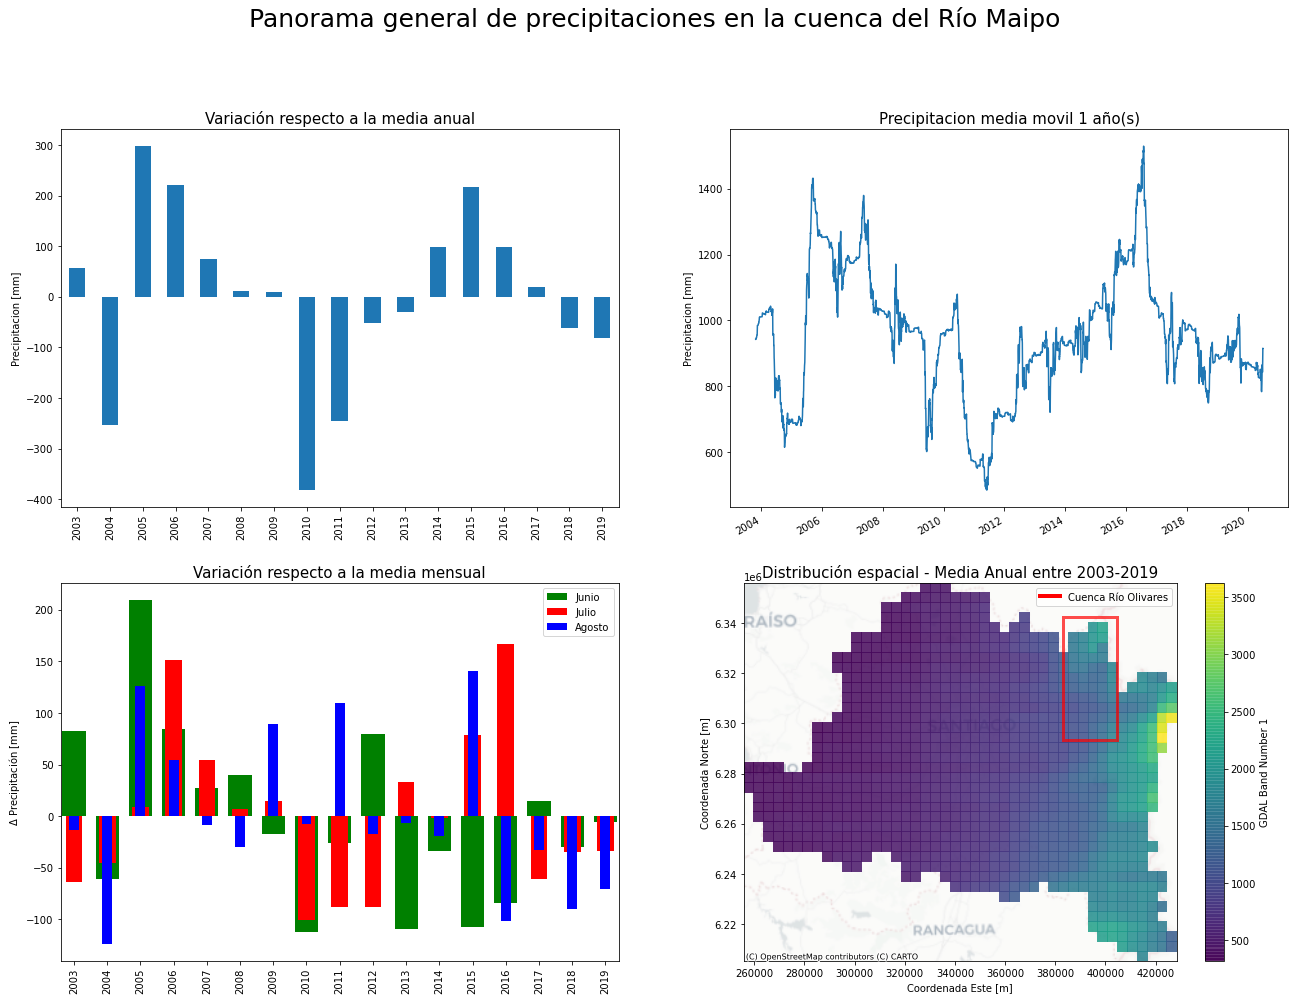

In [99]:
fig = plt.figure(figsize = (22,17))
n_roll = 1
cmap = 'viridis'
rect = plt.Rectangle((383192.1418, 6293291), 21311, 49098,
                     edgecolor="red", alpha=0.7, facecolor = 'none', linewidth = 3)
custom_lines = [Line2D([0], [0], color='red', lw=4)]


ax1 = fig.add_subplot(221)
dfA = df.resample('A').sum()
(dfA.iloc[:-1,:] - dfA.iloc[:-1,:].mean()).plot(ax = ax1, logy = False, legend = False, kind = 'bar')
labels = dfA.index.year.values[:-1]
ax1.set_xticklabels(labels)
plt.title('Variación respecto a la media anual', fontsize = 15)
plt.ylabel('Precipitacion [mm]')

ax2 = fig.add_subplot(222)
df.rolling(window = 365*n_roll, min_periods = 300).sum().plot(ax = ax2, logy = False, legend = False)
plt.title('Precipitacion media movil ' + str(n_roll) + ' año(s)', fontsize = 15)
plt.ylabel('Precipitacion [mm]')

ax3 = fig.add_subplot(223)
df_month = df.resample('M').sum()
jun = df_month[df_month.index.month == 6]
jul = df_month[df_month.index.month == 7]
aug = df_month[df_month.index.month == 8]
(jun - jun.mean()).plot(ax = ax3, logy = False, kind = 'bar', color = 'green', legend = False, width = 0.7)
(jul - jul.mean()).plot(ax = ax3, logy = False, kind = 'bar', color = 'red', legend = False, width = 0.5)
(aug - aug.mean()).plot(ax = ax3, logy = False, kind = 'bar', color = 'blue', legend = False, width = 0.3)
plt.legend(labels = ['Junio', 'Julio', 'Agosto'])
plt.title('Variación respecto a la media mensual', fontsize = 15)
locs = ax3.get_xticks()
labels = jun.index.year.values[:-1]
ax3.set_xticklabels(labels)
ax3.set_ylabel('$\Delta$ Precipitación [mm]')

ax4 = fig.add_subplot(224)
ds1_2D = ds1_yearsum_timmean.Band1.isel(time = 0)
ds1_2D.plot(ax = ax4, cmap = cmap, alpha = 0.85)
ax4.set_xlabel('Coordenada Este [m]')
ax4.set_ylabel('Coordenada Norte [m]')
ctx.add_basemap(ax = ax4, crs= 'EPSG:32719', source = ctx.providers.CartoDB.Positron, zoom = 8, alpha = 0.75)
plt.title('Distribución espacial - Media Anual entre 2003-2019', fontsize = 15)
ax4.add_patch(rect)
ax4.legend(custom_lines, ['Cuenca Río Olivares'])



plt.suptitle('Panorama general de precipitaciones en la cuenca del Río Maipo', fontsize = 25)
plt.show()

El panorama de las precipitaciones se completa ilustrando el comportamiento estacional de la cuenca (ilustrado en la figura siguiente). Como la lógica indica, invierno es la estación con mayor precipitación para la cuenca del Río Olivares, con valores sobre los 500 mm promedio durante dicho período, siendo un período clave para la recarga y reposición de aguas en la zona alta. Estos promedios fueron calculados para el período 2003-2019. 

<Figure size 1584x1224 with 0 Axes>

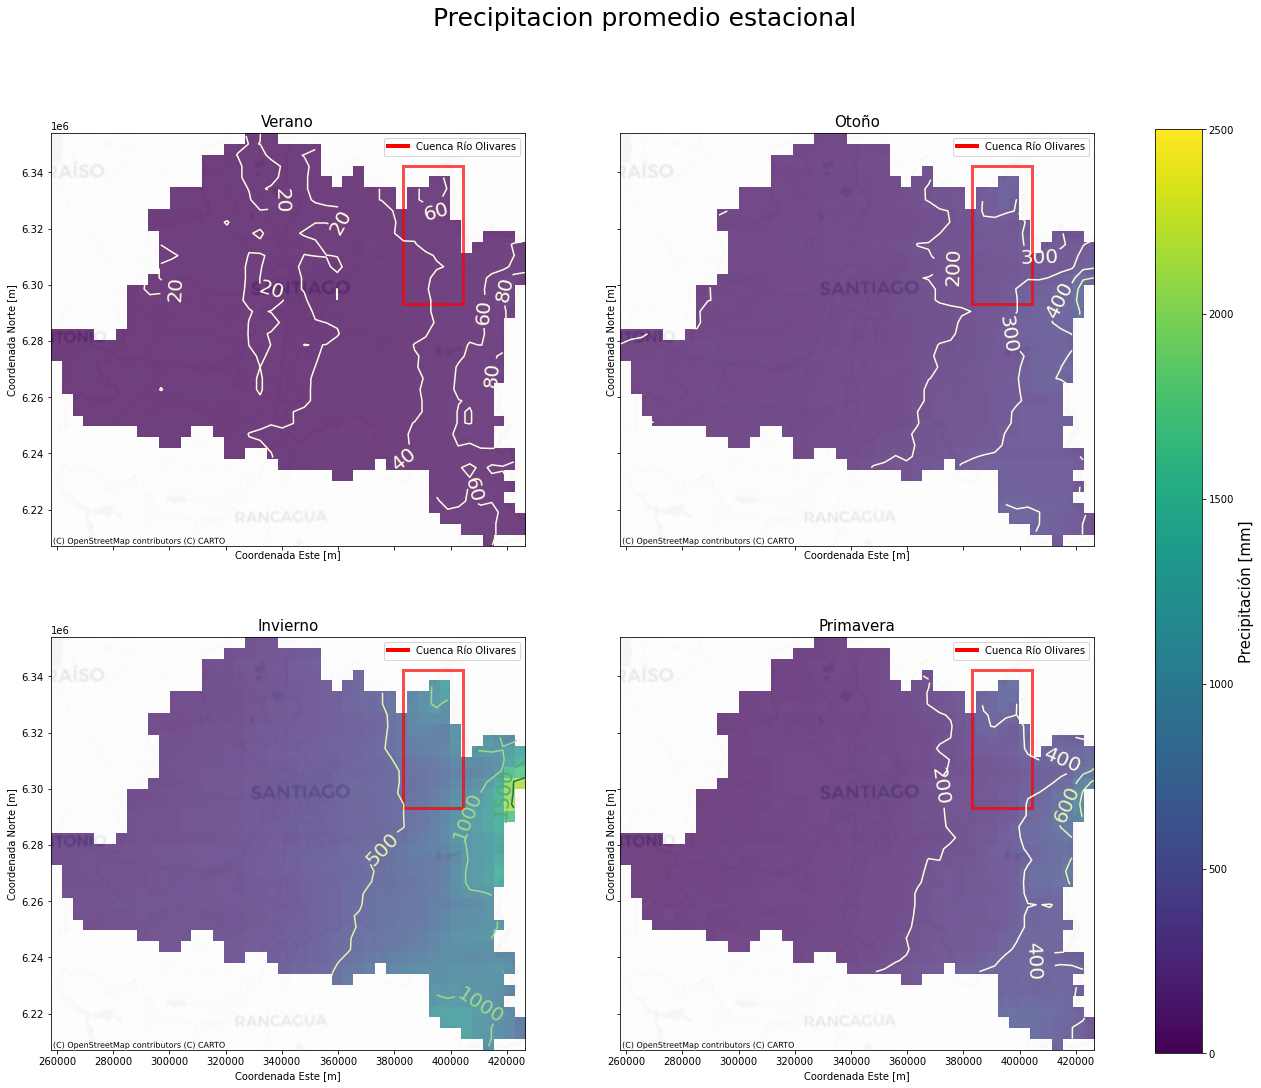

In [104]:
from matplotlib import cm

custom_lines = [Line2D([0], [0], color='red', lw=4)]

class nf(float):
    def __repr__(self):
        s = f'{self:.1f}'
        return f'{self:.0f}' if s[-1] == '0' else s

fig = plt.figure(figsize = (22, 17))
cmap = 'viridis'
#times = ds1_seas.time
#times[0]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(22,17)
fig.suptitle('Precipitacion promedio estacional', fontsize = 25)

images = []
for ax, t, est in zip(axs.flat, range(0,4), ['Verano', 'Otoño', 'Invierno', 'Primavera']):
        # Generate data with a range that varies from one plot to the next.
        data = ds1_seassum_yseasmean.Band1.isel(time = t)
        x = ds1_seas_mean.Band1.x
        y = ds1_seas_mean.Band1.y
        images.append(ax.imshow(data, extent = [x.min(), x.max(), y.min(), y.max()], origin = 'lower', cmap = cmap, alpha = 1.0))
        CS = xr.plot.contour(data, add_labels = True, ax = ax, levels = 6, cmap = 'YlGn')
        CS.levels = [nf(val) for val in CS.levels]
        images.append(CS)
        ctx.add_basemap(ax = ax, crs= 'EPSG:32719', source = ctx.providers.CartoDB.Positron, zoom = 8, alpha = 0.25)
        ax.label_outer()
        ax.set_title(est, fontsize = 15)
        if plt.rcParams["text.usetex"]:
            fmt = r'%r'
        else:
            fmt = '%r'
        ax.clabel(CS, CS.levels, inline=True, fmt = fmt, fontsize=20)
        ax.set_ylabel('Coordenada Norte [m]')
        ax.set_xlabel('Coordenada Este [m]')
        rect = plt.Rectangle((383192.1418, 6293291), 21311, 49098,
                     edgecolor="red", alpha=0.7, facecolor = 'none', linewidth = 3)
        ax.add_patch(rect)
        ax.legend(custom_lines, ['Cuenca Río Olivares'])
        

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.Normalize(vmin=vmin, vmax=vmax)
for im in images:
    im.set_norm(norm)


#fig.colorbar(images[0], ax=axs, orientation='vertical', fraction=.1)
cbar =fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical', fraction=.1)
cbar.set_label('Precipitación [mm]', rotation=90, fontsize = 15)
plt.show()

El impacto de la sequía se puede observar claramente en la figura siguiente, donde se muestra la variación con respecto a la media estacional medida en el 2019. La cuenca del río Olivares se ha visto particularmente afectada a lo largo de las 4 estaciones, mostrando déficit respecto al promedio en todo el 2019. Otras zonas de la cuenca han aumentado sus precipitaciones (primavera) sugiriendo relación con una de las hipótesis del cambio climático que es el “retardo” de las estaciones. 

/home/felipe/anaconda3/envs/netcdf/lib/python3.7/site-packages/ipykernel_launcher.py:38: MatplotlibDeprecationWarning: 
The DivergingNorm class was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use TwoSlopeNorm instead.


<Figure size 1584x1224 with 0 Axes>

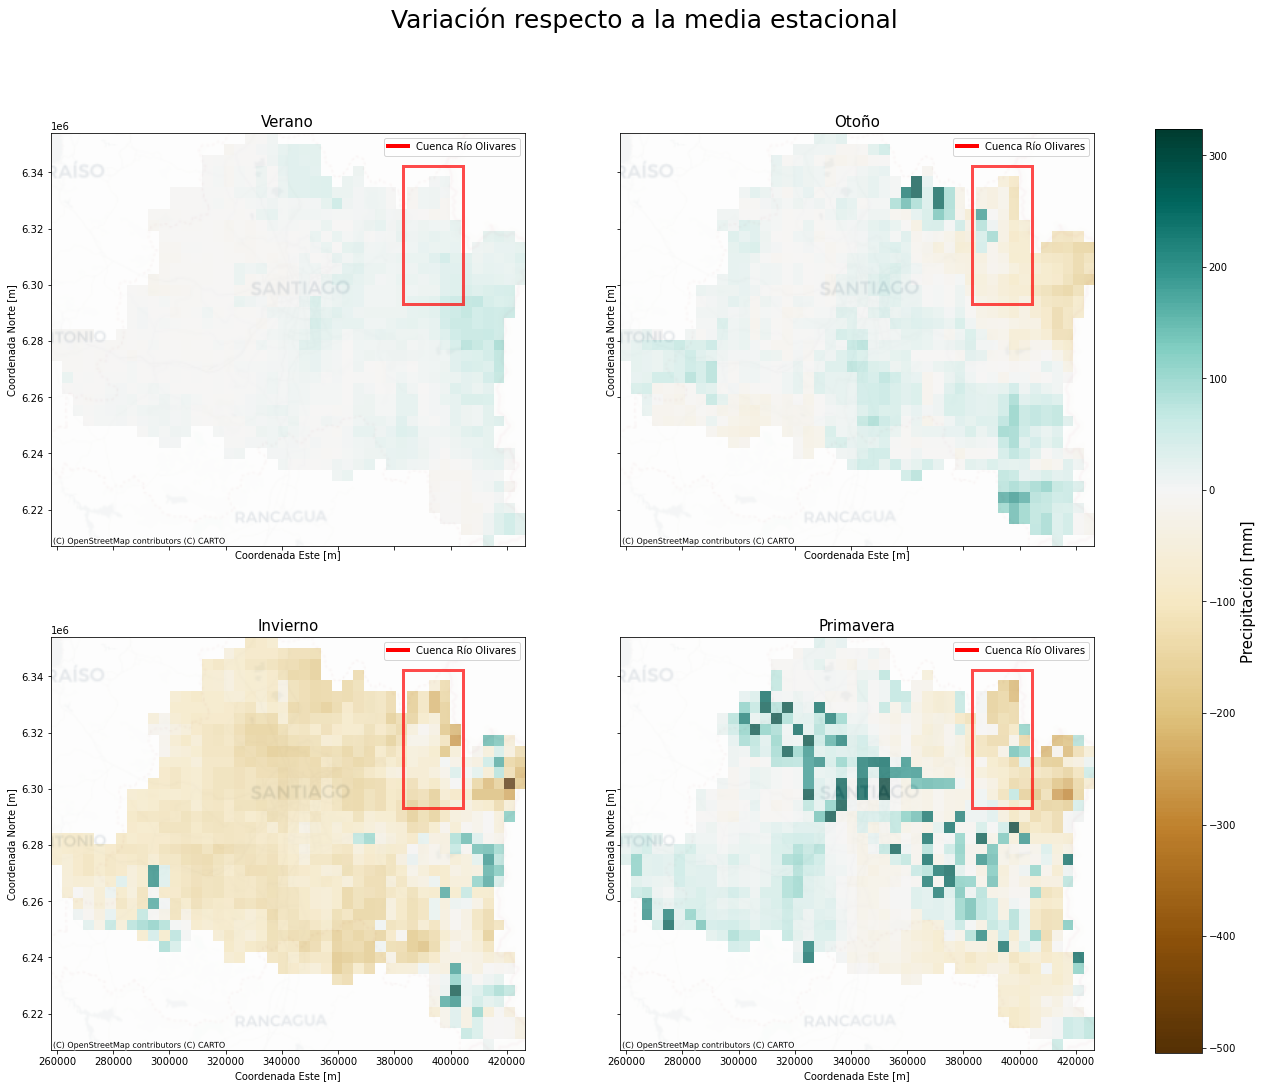

In [105]:
fig = plt.figure(figsize = (22, 17))
cmap = 'BrBG'
#times = ds1_seas.time
#times[0]

fig, axs = plt.subplots(2, 2)
fig.set_size_inches(22,17)
fig.suptitle('Variación respecto a la media estacional', fontsize = 25)

images = []
for ax, t1, t2, est in zip(axs.flat, range(-7,-3), range(0,4), ['Verano', 'Otoño', 'Invierno', 'Primavera']):
        # Generate data with a range that varies from one plot to the next.
        data = ds1_seassum.Band1.isel(time = t1) -  ds1_seassum_yseasmean.Band1.isel(time = t2)
        x = ds1_seas_mean.Band1.x
        y = ds1_seas_mean.Band1.y
        images.append(ax.imshow(data, extent = [x.min(), x.max(), y.min(), y.max()], origin = 'lower', cmap = cmap, alpha = 1.0))
        #CS = xr.plot.contour(data, add_labels = True, ax = ax, levels = 4, cmap = 'viridis')
        #CS.levels = [nf(val) for val in CS.levels]
        #images.append(CS)
        ax.label_outer()
        ax.set_title(est, fontsize = 15)
        if plt.rcParams["text.usetex"]:
            fmt = r'%r'
        else:
            fmt = '%r'
        #ax.clabel(CS, CS.levels, inline=True, fmt = fmt, fontsize=10)
        ax.set_ylabel('Coordenada Norte [m]')
        ax.set_xlabel('Coordenada Este [m]')
        rect = plt.Rectangle((383192.1418, 6293291), 21311, 49098,
                     edgecolor="red", alpha=0.7, facecolor = 'none', linewidth = 3)
        ax.add_patch(rect)
        ax.legend(custom_lines, ['Cuenca Río Olivares'])
        ctx.add_basemap(ax = ax, crs= 'EPSG:32719', source = ctx.providers.CartoDB.Positron, zoom = 8, alpha = 0.25)

# Find the min and max of all colors for use in setting the color scale.
vmin = min(image.get_array().min() for image in images)
vmax = max(image.get_array().max() for image in images)
norm = colors.DivergingNorm(vmin=vmin, vcenter=0, vmax=vmax)
for im in images:
    im.set_norm(norm)


#fig.colorbar(images[0], ax=axs, orientation='vertical', fraction=.1)
cbar =fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax=axs, orientation='vertical', fraction=.1)
cbar.set_label('Precipitación [mm]', rotation=90, fontsize = 15)
plt.show()

También podemos ver un video de cómo ha variado la media estacional a lo largo del tiempo

In [1]:
from IPython.display import Video
Video("pp_anom.mp4")

ValueError: To embed videos, you must pass embed=True (this may make your notebook files huge)
Consider passing Video(url='...')

## Evolución temporal de la temperatura

La temperatura de la superficie terrestre se obtiene a partir del análisis de bandas espectrales de imágenes satelitales MODIS (MOD11A2) de resolución de 1km x 1km a escala diaria entre el 01-01-2003 y el 24-11-2020. 


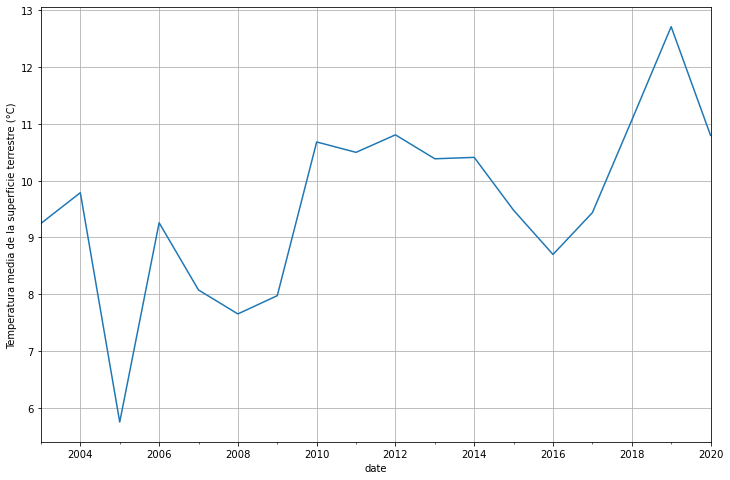

In [38]:
df_t = pd.read_excel('modis_temp.xlsx', index_col = 1, parse_dates = True)
plt.figure(figsize = (12,8))
df_t['LST'].resample('YS').mean().plot()
plt.ylabel('Temperatura media de la superficie terrestre (°C)')
plt.grid()


# Análisis de glaciares

## Delimitación de glaciares

La delimitación de la cobertura de los glaciares de la cuenca del río Olivares en el tiempo se realizó de acuerdo a la metodología definida en HAIRETI (2017). Esta metodología consiste en utilizar las bandas de las imágenes recolectadas por Landsat, y calcular la razón entre la banda del especto infrarrojo cercano y la del infrarrojo de onda corta, además de la banda térmica infrarroja. Estas imágenes se cargan en la plataforma del Dataobservatory en forma de xarrays de Python (http://xarray.pydata.org/en/stable/). Luego, mediante algebra de estos arreglos n-dimensionales se calculan las razones de HAIRETI (2017) para cada imagen diaria.  

El siguiente paso consiste en definir umbrales para los valores de estas razones obtenidos de este cálculo de imágenes. El umbral mínimo que caracteriza una zona glaciar se definió igual a 3, cercano al valor de 1,8 mencionado en HAIRETI (2017), el cual había sido calibrado para identificar glaciares en la zona de los alpes Suizos. Así, se filtraron las celdas cuyo valor sea mayor que este umbral, definiendo la zona cubierta por los glaciares de la cuenca del río Olivares. Las imágenes de la zona cubierta por los glaciares de la cuenca del río Olivares se guardaron en forma de arreglos n-dimensionales (xarray) y se exportaron a formato NetCDF.  

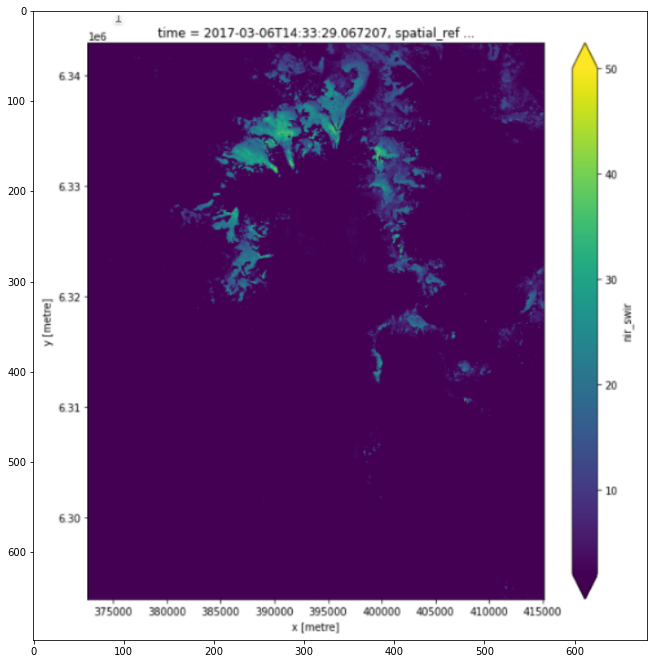

In [27]:
img = mpimg.imread('Espectro_glaciar.png')
plt.figure(figsize = (11,17))
imgplot = plt.imshow(img)
plt.show()

## Filtrado de nubes
Al utilizar las bandas espectrales de los sensores del satélite Landsat 8, se deben corregir los valores obtenidos para las imágenes que contengan nubes. Para ello, se descargaron los valores de control de calidad de cada imagen correspondientes a “pixel_qa”, los cuales indican los valores de los pixeles que contienen nubes. Al mismo tiempo, para cada registro diario de la zona cubierta por glaciares, se buscaron los pixeles que contenían nubes y se les asigno un valor nulo. Luego, estos valores nulos se interpolaron mediante la función “interpolate_na” de xarray.  

## Delimitación de la cuenca del río Olivares 
Las coberturas glaciares del área de interés filtradas por nubes se cortaron superponiendo la delimitación oficial de la cuenca, elaborada por DGA-CIREN (2014). 


## Cálculo del area glaciar

El área glaciar de cada imagen satelital diaria se calculó contando los pixeles que se clasificaron como glaciar por sobre el umbral definido en base a la metodología de HAIRETI (2017); Paul et al. (2016) y Paul (2016), filtrados por nubosidad y que se encuentran dentro de la cuenca del río Olivares. Como la resolución de las imágenes satelitales es de 30mx30m, se multiplicó el número de celdas cubiertas por glaciares por 900 $m^2$ y se dividió por 1.000.000 para convertirla a $km^2$. 

## Evolución temporal de la cobertura glaciar 

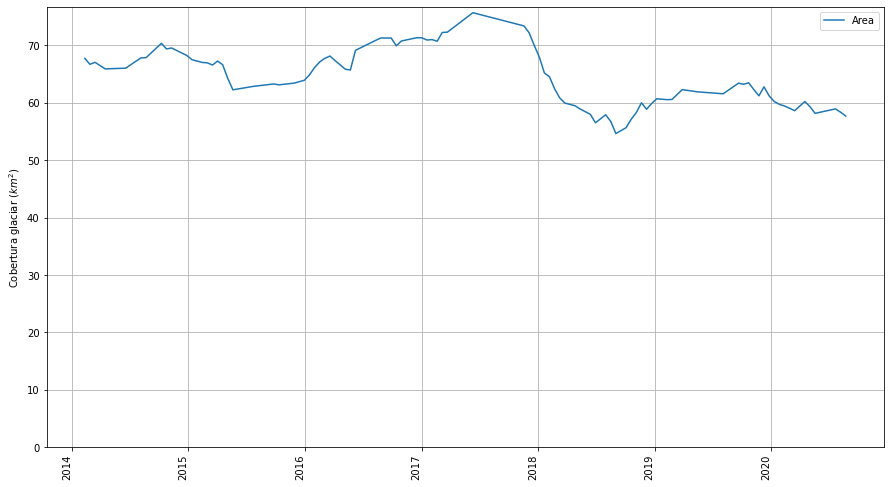

In [37]:
cobertura_temporal = pd.read_csv('areas_glaciares_2003_2020.csv', index_col = 0, parse_dates = True)
ax = cobertura_temporal.plot(rot = 90, figsize = (15, 9))
ax.set_ylabel('Cobertura glaciar ($km^2$)')
ax.set_xlabel('')
ax.set_ylim(bottom =0)
ax.grid()
    


## Retroceso del área cubierta por los glaciares
Se promedió la cobertura del área glaciar entre los años 2013 y 2020, comparando el retroceso efectivo de la cubierta de hielo, la cual se muestra en la figura 4. Mediante el cálculo de las coberturas glaciares, se obtiene un retroceso del área cubierta de 15,5% al 2020 con respecto a 2013. 

Text(0, 0.5, 'Norte (m)')

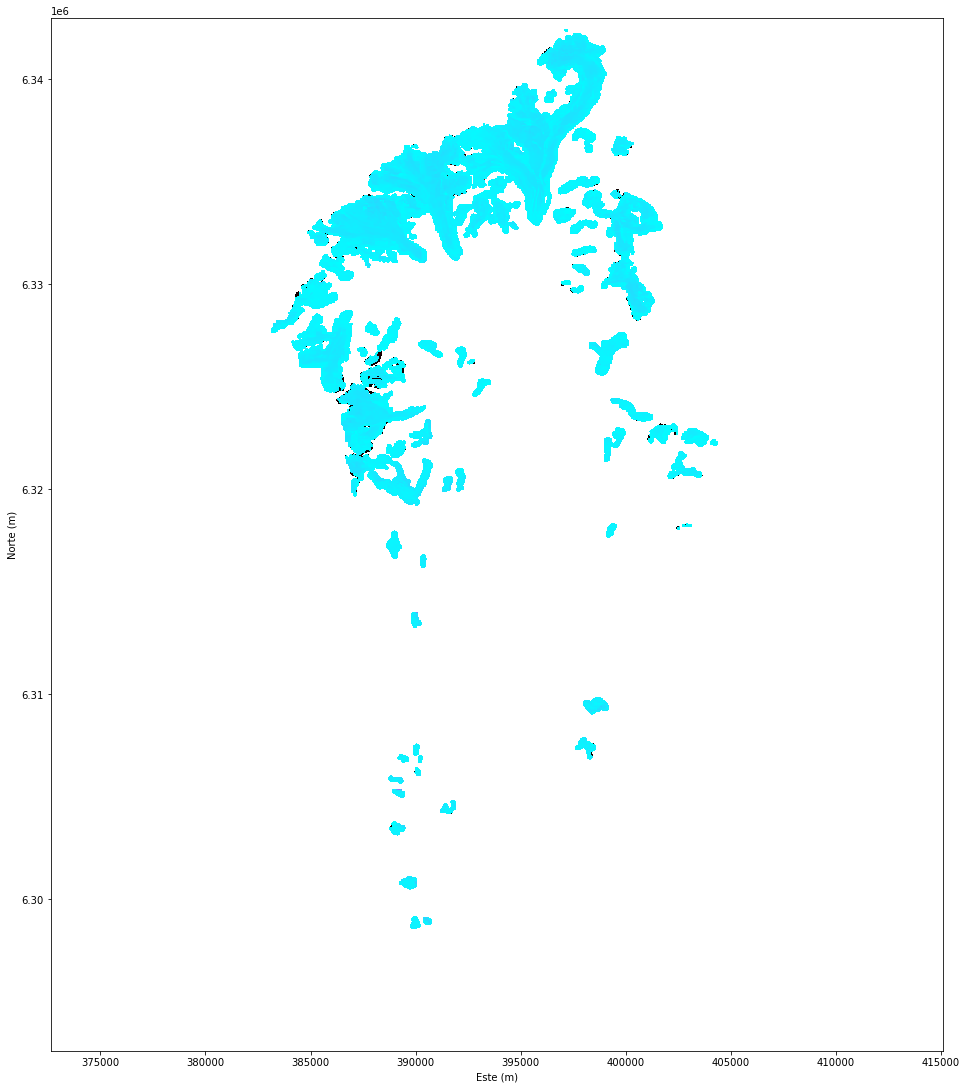

In [29]:
cobertura_g_2013 = xarray.open_dataset('cobertura_glaciar_media_2013.nc')
cobertura_g_2020 = xarray.open_dataset('cobertura_glaciar_media_2020.nc')
x = cobertura_g_2013.x.values
y = cobertura_g_2013.y.values

#   
plt.figure(figsize = (16,19)) 
plt.pcolormesh(x, y, cobertura_g_2013.__xarray_dataarray_variable__.values, cmap = 'afmhot', vmin = 3, vmax = 200, linewidths = 4, shading='auto')

plt.pcolormesh(x, y, cobertura_g_2020.__xarray_dataarray_variable__.values, cmap = 'cool', vmin = 3, vmax = 200, linewidths = 0.1, shading='auto')

plt.xlabel('Este (m)')
plt.ylabel('Norte (m)')

# Referencias
DGA-CIREN (2014). Redefinición de la clasificación red hidrográfica a nivel nacional.  

HAIRETI, A. (2017). Delineation of debris-covered glaciers based on a combination of geomorphometric parameters and Landsat [TIR/(NIR/SWIR)] band ratio (Doctoral dissertation, 千葉大学= Chiba University). 

Hsu, K., H.V. Gupta, X. Gao, and S. Sorooshian, Rainfall Estimation from Satellite Imagery, Chapter 11 of Artificial Neural Networks in Hydrology, Edited by R.S. Govindaraju and A.R. Rao, Published by Kluwer Academic Publishers, P.O. Box 17, 3300 AA Dordrecht, The Netherlands, pp 209-234, 2000. 

Paul, F. (2016). A comparison of glacier classification with Sentinel 2 MSI and Landsat 8 OLI. EGUGA, EPSC2016-9182. 

Paul, F., Winsvold, S. H., Kääb, A., Nagler, T., & Schwaizer, G. (2016). Glacier remote sensing using Sentinel-2. Part II: Mapping glacier extents and surface facies, and comparison to Landsat 8. Remote Sensing, 8(7), 575. 